This is a notebook for coding a more compact and neater program to calculate the correlation functions of various local operators

In [1]:
# import the model file we designed
"""
    Here we want to clarify that the 'kitaev_ladder_snake1.py' file
    is different from the 'kitaev_ladder_snake.py' in that the *1 file 
    uses the original representation of xyz,
    i.e. Jz stands for the sigmazsigmaz interactions which starts from
    the first pair of neighbors; Jx being the second pair; and Jy being
    the third-nearest-neighbors.
    
    The purpose of designing so many different 1D correspondences is 
    to serve for different phases.
    For example, when the Jx interaction is very weak, the optimal 
    choice is to make Jx as the third-nearest neighbors; when Jy is 
    weak the similar case holds.
"""
from kitaev_ladder_snake1 import run_atomic, save_after_run, finite_scaling, load_data, fDMRG_KL

# the folder name for storing data
folder_prefix = 'snake/'

# generate the function for running and storing the data in the folder we want
run_save = save_after_run(run_atomic, folder_prefix=folder_prefix)

In [2]:
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
from scipy import optimize

import scipy.sparse as sparse

In [68]:
from operator_algebra import gen_local_order_parameter_candidates

Here we define another function to extract the correlation function.

This one should be more general, more compact, and more friendly than the previous one.

In [36]:
###### ref: the previous examples ######
# def double_local_op(psi, op='Sx', i0=1, d=1):
#     return psi.expectation_value_term(term=[(op, i0), (op, i0+1), (op, i0+d*2), (op, i0+d*2+1)])*16
# def double_local_op_corr_func(psi, op='Sx', i0=1, dN=9):
#     return [double_local_op(psi, op=op, i0=i0, d=d) for d in range(dN)]
########################################

"""
    The function takes directly the list of operator terms as input.
    Operator Term: the tuple of `opstr` and `pos`, e.g. ('Sx', 0)
"""
def local_op_correlation(
    psi, # the input MPS
    term_list:list, # the operator list to calc
    max_L = 40, # the maximum range of unitcells to cover
    unitcell_size=2, # the size, i.e. the number of physical site, of each unitcell
    spin_rescale_coeff=2, # the rescaling coef from the model, given to 2 by default for spin-1/2 operator Sx Sy Sz
):
    d_list = range(max_L)
    corr_list = []
    for l in d_list: # calculate the value of each site
        original_term = term_list
        shifted_term = [(t[0], t[1]+l*unitcell_size) for t in original_term]
        corr_value = psi.expectation_value_term(term=original_term + shifted_term)
        coef = spin_rescale_coeff**(len(original_term) * 2) # in total there will be `2*len(original_term)` spin operators
        final_corr = corr_value * coef
        corr_list.append(final_corr)
        pass
    
    return corr_list


In [53]:
def list_to_tuple(
    ops: list,
):
    for i in ops:
        assert type(i) is int
        assert i==0 or i==1 or i==2 or i==3
        
    tuple_list = []
    for index, number in enumerate(ops):
        if number==0: continue
        op = 'Sx' if number==1 else ('Sy' if number==2 else 'Sz')
        tuple_list.append((op, index))
    return tuple_list
list_to_tuple([3,2,3])

[('Sz', 0), ('Sy', 1), ('Sz', 2)]

Note that here we choose the file `kitaev ladder snake 1` which is better performed in the x-dominated region `|Jx| > |Jy|`.

In [7]:
Jx = 1.75
Jy = 0.25
Jz = 1.0

In [9]:
chi_list = [2**k for k in range(3, 8)]
initial_psi = None

for chi in chi_list:
    result = run_atomic(Jx=Jx, Jy=Jy, Jz=Jz, chi=chi, initial_psi=initial_psi, L=40, bc='periodic', bc_MPS='infinite')
    psi = result['psi']
    initial_psi = psi.copy()
    pass

psi = initial_psi.copy()

Reading 'L'=40 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='infinite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.75 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.25 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  8 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=Tru

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['P_tol'] for config lanczos_params

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 4080
Energy = -0.2396616072473634, S = nan, norm_err = 4.6e-09
Current memory usage 227.1 MB, time elapsed: 57.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4514e-09, max_E_trunc = 4.1100e-09
MPS bond dimensions: [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
Updating environment
.....

DMRG finished after 40 sweeps.
total size = 11280, maximum chi = 32


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000153-1.1275057882982849e-15j)
After the canonicalization:
Bond dim =  [26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32, 26, 32]
Computing properties
Optimizing
Loop for chi=32 done.
============================== END ==============================
Reading 'L'=40 for config KitaevLadderSnakeCompactModel
Rea

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2119: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000258+6.252913419674668e-16j)
After the canonicalization:
Bond dim =  [28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=40 for config KitaevLadderSnakeCompactModel
Read

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2119: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000023-2.3866450183194773e-15j)
After the canonicalization:
Bond dim =  [28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36, 28, 36]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================


In [12]:
es1, es2 = (psi.entanglement_spectrum()[0], psi.entanglement_spectrum()[1])

In [13]:
es1

array([ 0.69837276,  0.69837276,  5.9552003 ,  5.9552003 , 11.21202783,
       11.21202783, 16.46885536, 16.46885536, 16.46885536, 16.46885536,
       21.72568281, 21.72568286, 21.7256829 , 21.72568299, 26.98250463,
       26.98250922, 26.98251125, 26.98251379, 26.98252693, 26.98253509,
       32.23879277, 32.23896577, 32.2393482 , 32.23941511, 32.23966216,
       32.23984969, 32.24048986, 32.24286843])

In [14]:
es2

array([ 0.73169076,  0.73169076,  3.96973683,  3.96973683, 11.20812305,
       11.20812305, 11.31988309, 11.31988309, 14.44616913, 14.44616913,
       14.55792916, 14.55792916, 18.48406656, 18.48406657, 21.72211263,
       21.72211288, 21.79631532, 21.79631537, 24.96068061, 24.96068206,
       25.03436047, 25.034364  , 28.19870229, 28.19873416, 28.96050678,
       28.96053565, 29.07233882, 29.07243851, 32.1614978 , 32.18596594,
       32.18769963, 32.20041442, 32.31081033, 32.32578373, 32.48245918,
       32.50182345])

In [17]:
xx_corr = psi.correlation_function('Sx', 'Sx')

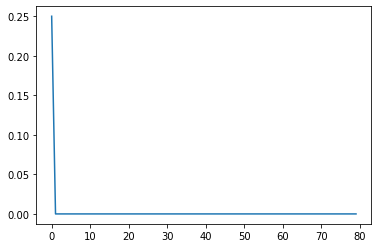

In [19]:
x_f = xx_corr[0,:]
plt.plot(x_f)

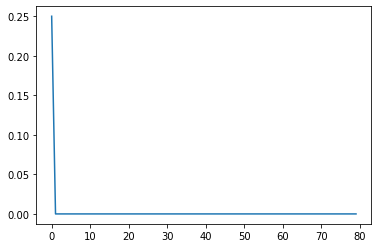

In [21]:
xy_corr = psi.correlation_function(['Sx', 'Sy'], ['Sx', 'Sy'])
xy_f = xy_corr[0, :]
plt.plot(xy_f)

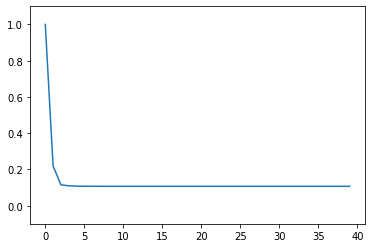

In [81]:
term_list = [3, 3]
tuple_list = list_to_tuple(term_list)
ret_ZZ = local_op_correlation(psi, tuple_list)
plt.ylim([-.1,1.1])
plt.plot(ret_ZZ)

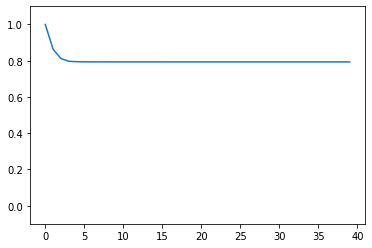

In [84]:
term_list = [0, 1, 1]
tuple_list = list_to_tuple(term_list)
ret_IXX = local_op_correlation(psi, tuple_list)
plt.ylim([-.1,1.1])
plt.plot(ret_IXX)

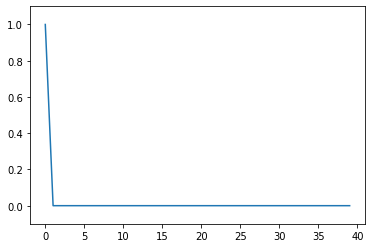

In [83]:
term_list = [1, 1]
tuple_list = list_to_tuple(term_list)
ret_XX = local_op_correlation(psi, tuple_list)
plt.ylim([-.1,1.1])
plt.plot(ret_XX)

### XZX operator

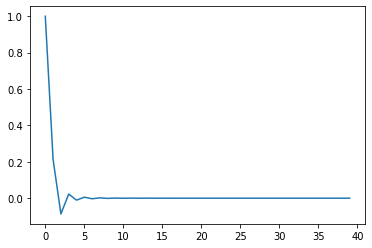

In [54]:
term_list = [1, 3, 1]
tuple_list = list_to_tuple(term_list)
ret_xzx = local_op_correlation(psi, tuple_list)
plt.plot(ret_xzx)

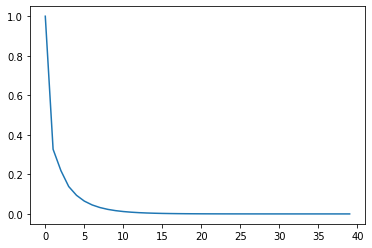

### Disorder parameter

In [24]:
x_disorder_corr = psi.correlation_function('Sx', 'Sx', opstr='Sx')


In [30]:
x_dis = x_disorder_corr[0, :]
x_dis = x_dis[::2]
for i in range(len(x_dis)):
    x_dis[i] *= 2**(2*(i+1))
    x_dis[i] = abs(x_dis[i])

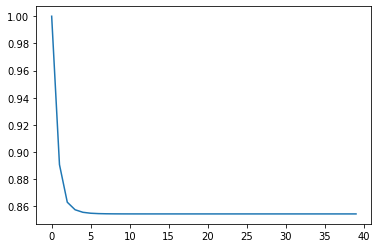

In [33]:
plt.plot(x_dis)

### XY operator

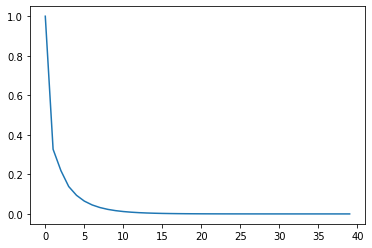

In [44]:
# test
ret = local_op_correlation(psi, [('Sx', 0), ('Sy', 1)])
plt.plot([abs(v) for v in ret])

### XY operator
`[1, 2]`

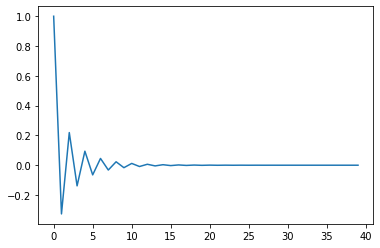

In [66]:
term_list = [1, 2]
tuple_list = list_to_tuple(term_list)
ret_XY = local_op_correlation(psi, tuple_list)
plt.plot(ret_XY)

### YX operator
`[2, 1]`

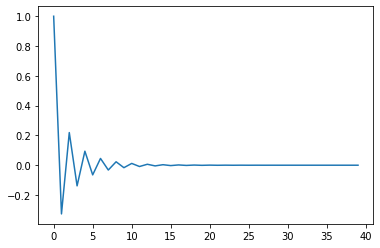

In [56]:
term_list = [2, 1]
tuple_list = list_to_tuple(term_list)
ret_YX = local_op_correlation(psi, tuple_list)
plt.plot(ret_YX)

### XZX operator

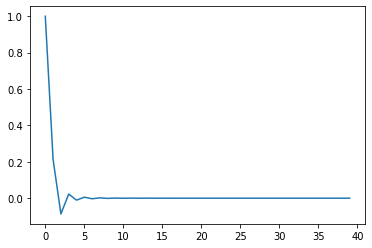

In [54]:
term_list = [1, 3, 1]
tuple_list = list_to_tuple(term_list)
ret_xzx = local_op_correlation(psi, tuple_list)
plt.plot(ret_xzx)

### YIX operator

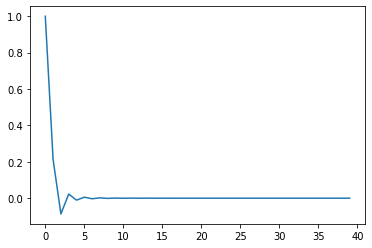

In [54]:
term_list = [2, 0, 1]
tuple_list = list_to_tuple(term_list)
ret_xzx = local_op_correlation(psi, tuple_list)
plt.plot(ret_xzx)

### IXIY operator
`[0, 1, 0, 2]`

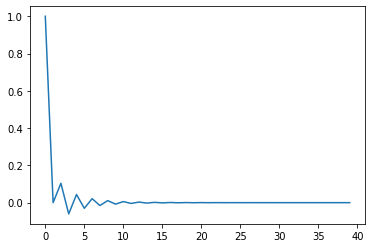

In [57]:
term_list = [0, 1, 0, 2]
tuple_list = list_to_tuple(term_list)
ret_IXIY = local_op_correlation(psi, tuple_list)
plt.plot(ret_IXIY)

### IXZX operator
`[0, 1, 3, 1]`

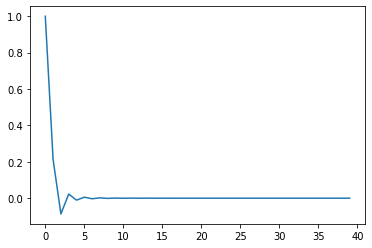

In [58]:
term_list = [0, 1, 3, 1]
tuple_list = list_to_tuple(term_list)
ret_IXZX = local_op_correlation(psi, tuple_list)
plt.plot(ret_IXZX)

### XYZZ operator
`[1, 2, 3, 3]`

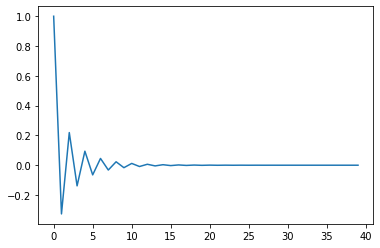

In [59]:
term_list = [1, 2, 3, 3]
tuple_list = list_to_tuple(term_list)
ret_XYZZ = local_op_correlation(psi, tuple_list)
plt.plot(ret_XYZZ)

### XZYZ operator
`[1, 3, 2, 3]`

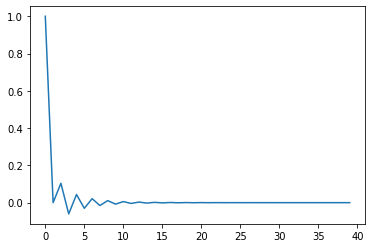

In [60]:
term_list = [1, 3, 2, 3]
tuple_list = list_to_tuple(term_list)
ret_XZYZ = local_op_correlation(psi, tuple_list)
plt.plot(ret_XZYZ)

### YXZZ operator
`[2, 1, 3, 3]`

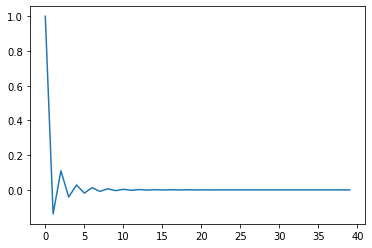

In [61]:
term_list = [2, 1, 3, 3]
tuple_list = list_to_tuple(term_list)
ret_YXZZ = local_op_correlation(psi, tuple_list)
plt.plot(ret_YXZZ)

### ZYIY operator
`[3, 2, 0, 2]`

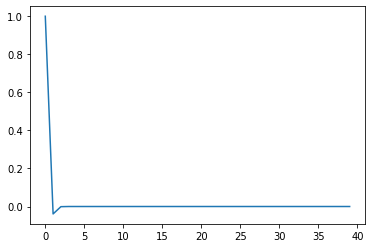

In [62]:
term_list = [3, 2, 0, 2]
tuple_list = list_to_tuple(term_list)
ret_ZYIY = local_op_correlation(psi, tuple_list)
plt.plot(ret_ZYIY)

### ZYZX operator
`[3, 2, 3, 1]`

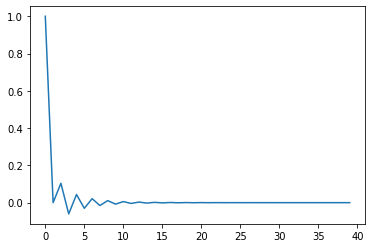

In [63]:
term_list = [3, 2, 3, 1]
tuple_list = list_to_tuple(term_list)
ret_ZYZX = local_op_correlation(psi, tuple_list)
plt.plot(ret_ZYZX)

### ZZXY operator
`[3, 3, 1, 2]`

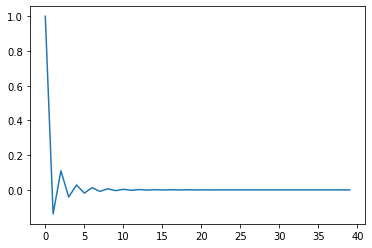

In [64]:
term_list = [3, 3, 1, 2]
tuple_list = list_to_tuple(term_list)
ret_ZZXY = local_op_correlation(psi, tuple_list)
plt.plot(ret_ZZXY)

### ZZYX operator
`[3, 3, 2, 1]`

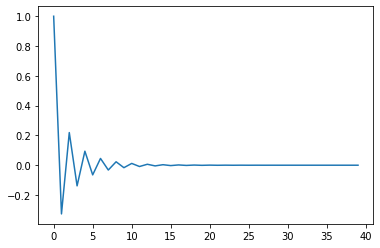

In [65]:
term_list = [3, 3, 2, 1]
tuple_list = list_to_tuple(term_list)
ret_ZZYX = local_op_correlation(psi, tuple_list)
plt.plot(ret_ZZYX)

I am tired of manually inputting all the candidates.
Therefore I created a function to generate all of them.

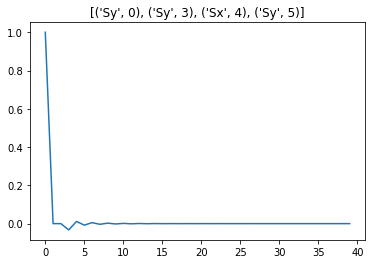

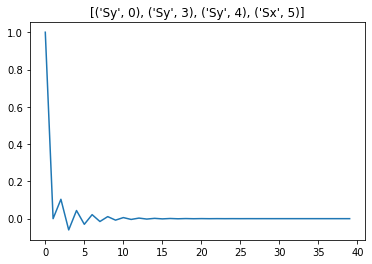

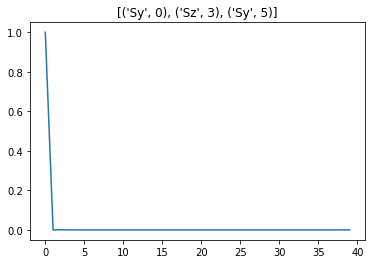

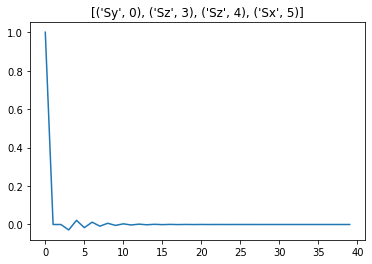

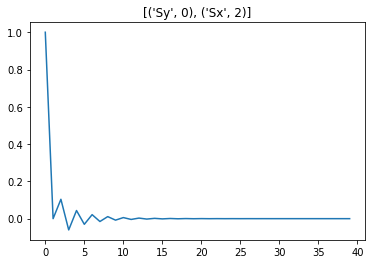

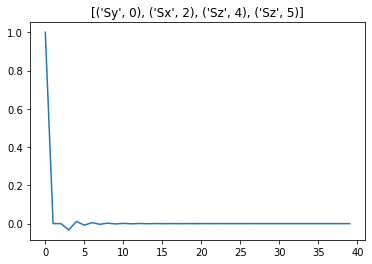

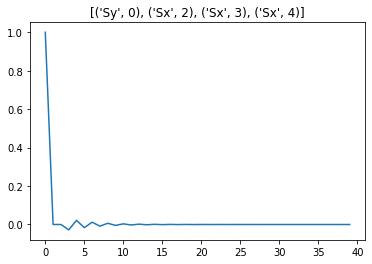

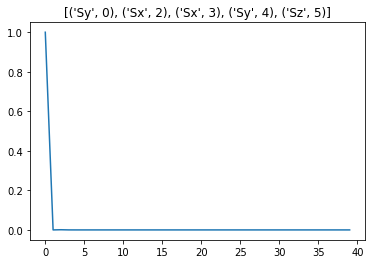

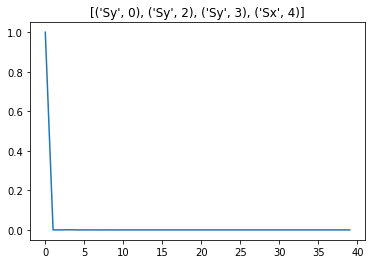

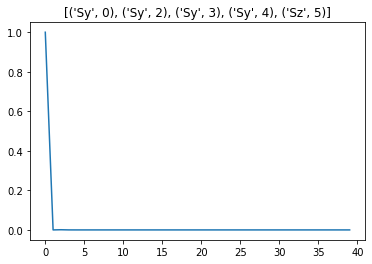

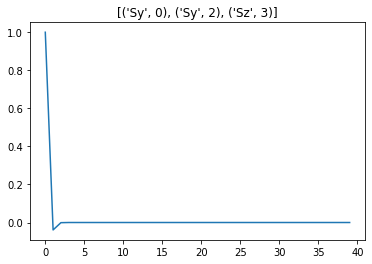

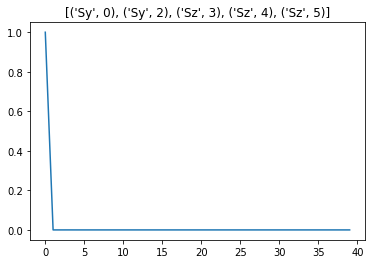

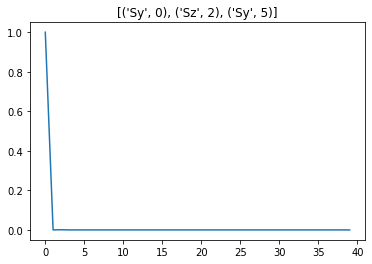

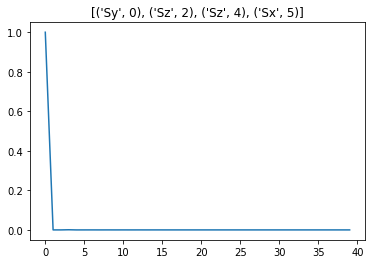

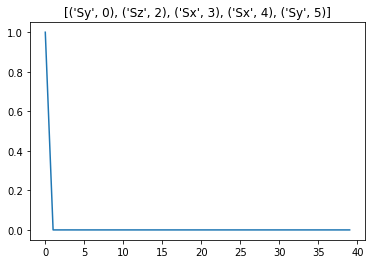

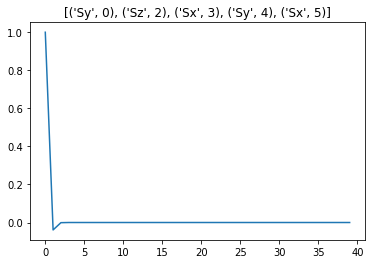

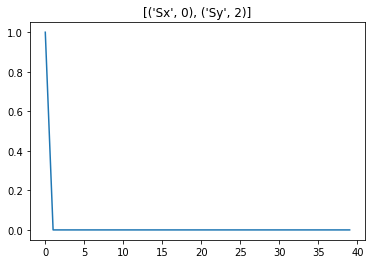

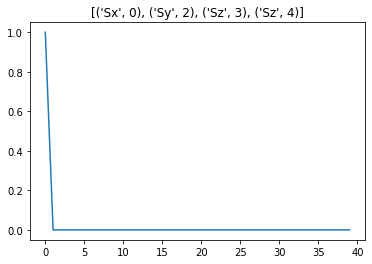

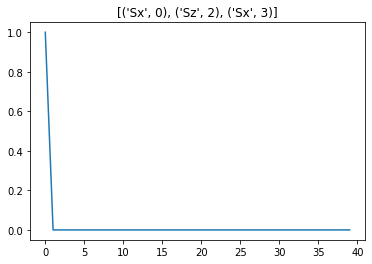

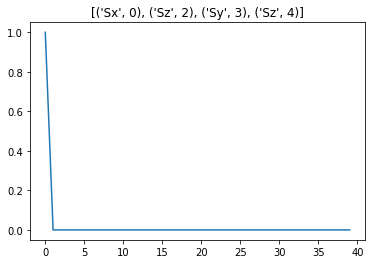

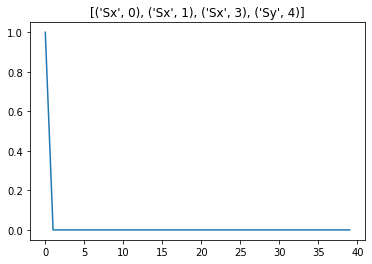

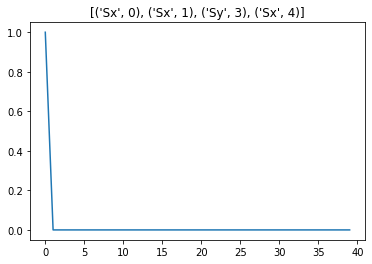

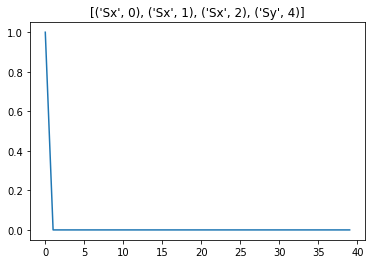

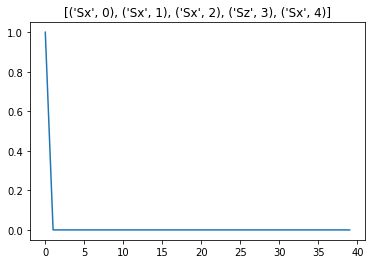

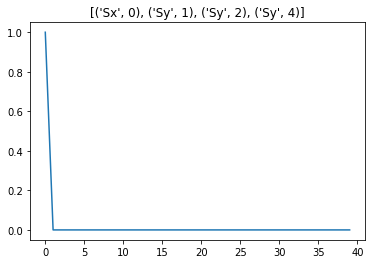

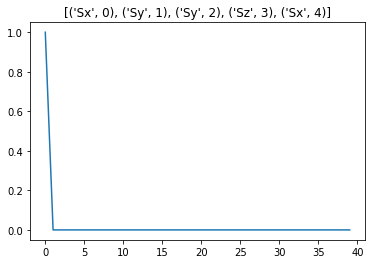

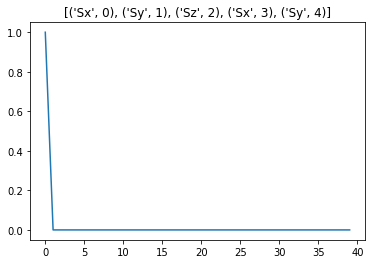

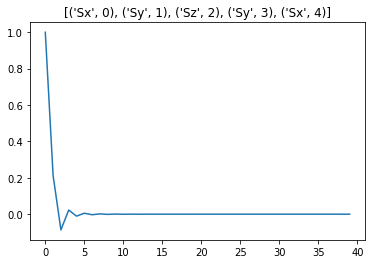

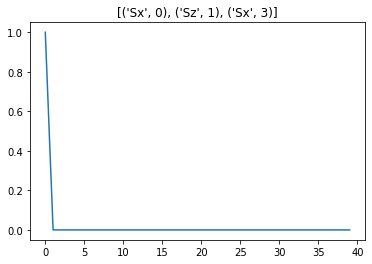

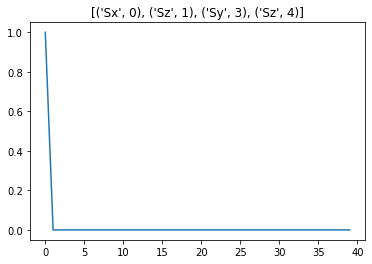

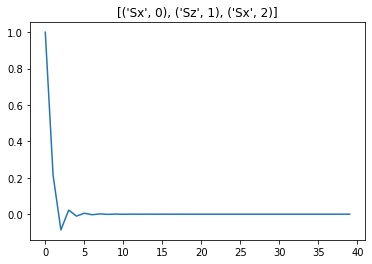

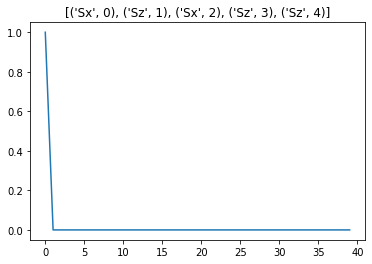

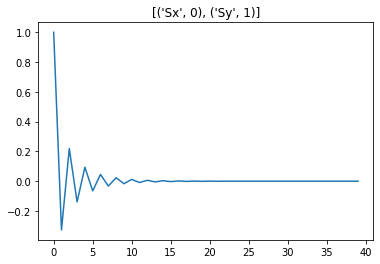

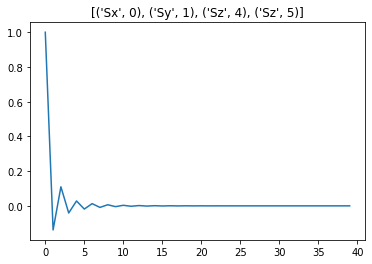

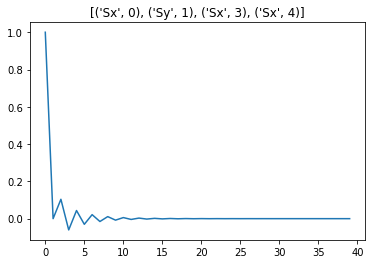

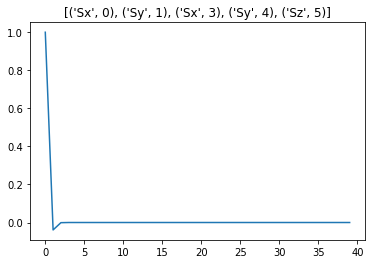

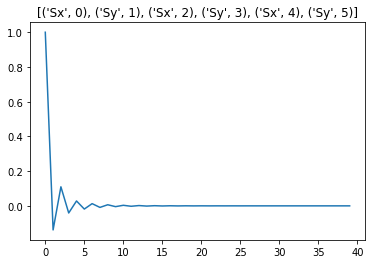

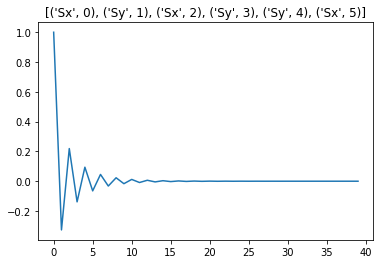

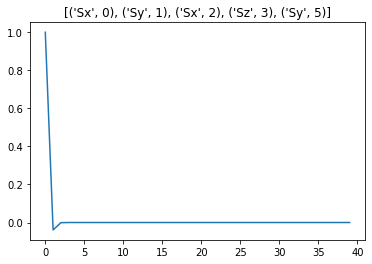

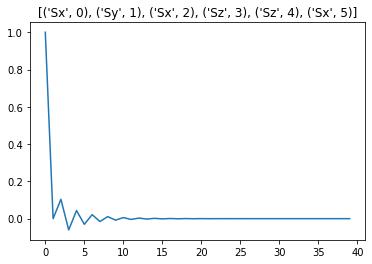

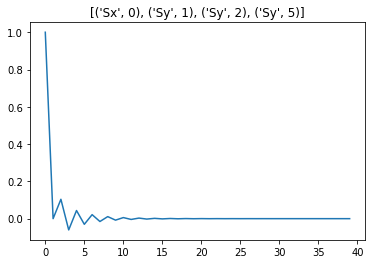

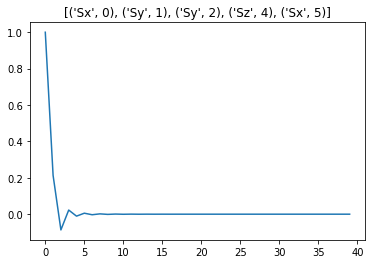

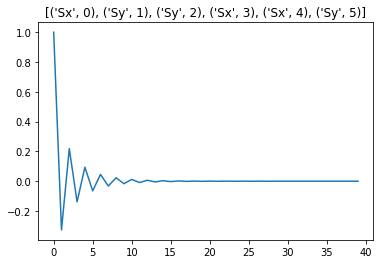

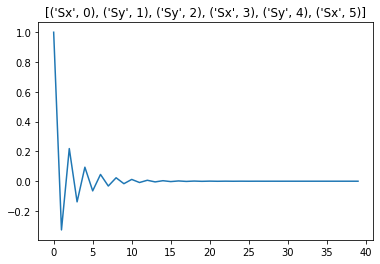

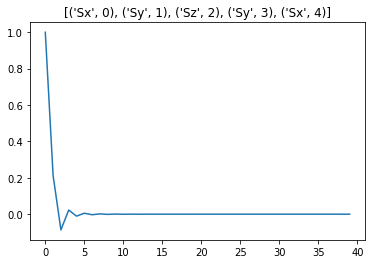

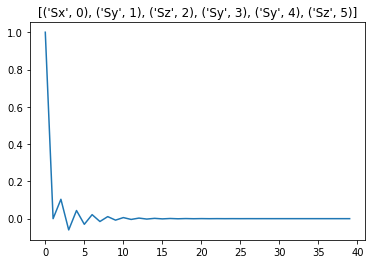

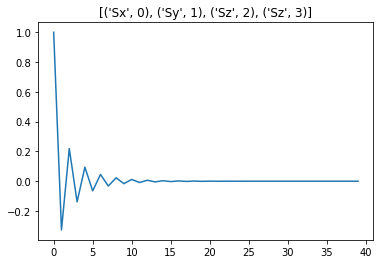

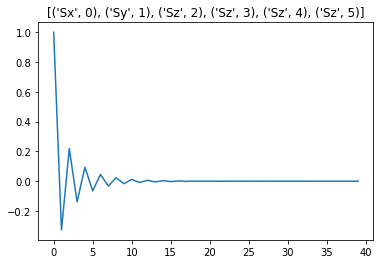

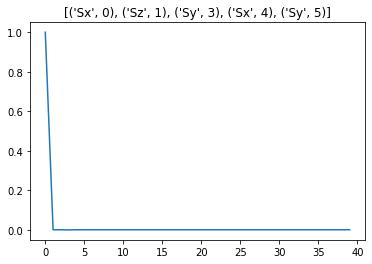

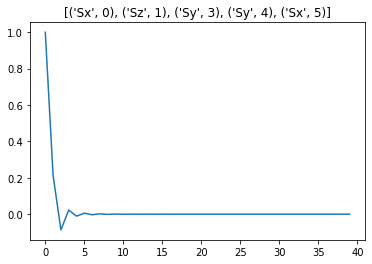

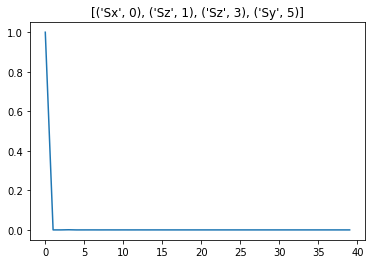

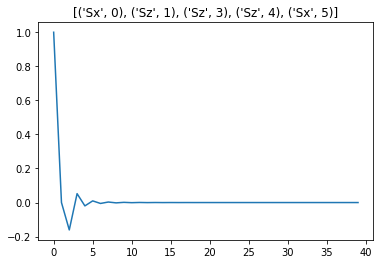

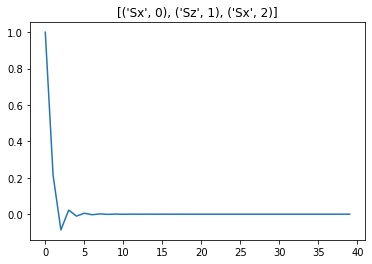

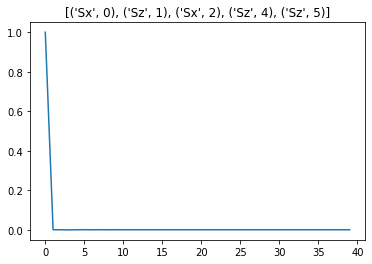

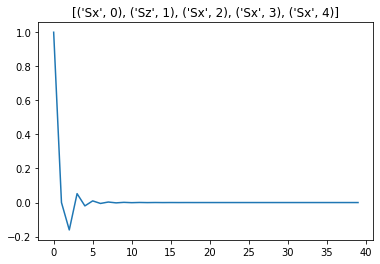

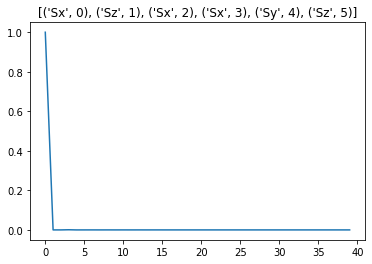

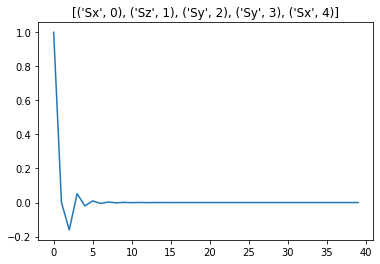

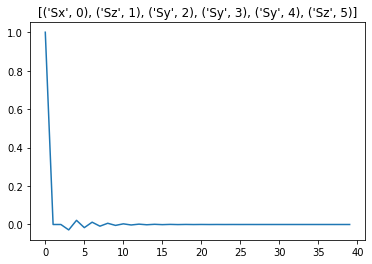

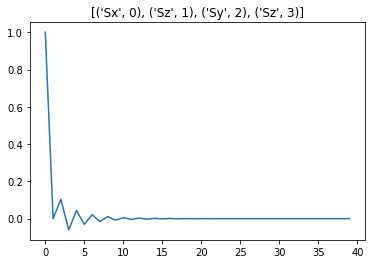

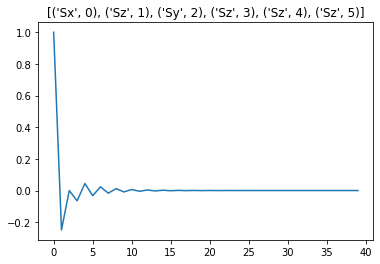

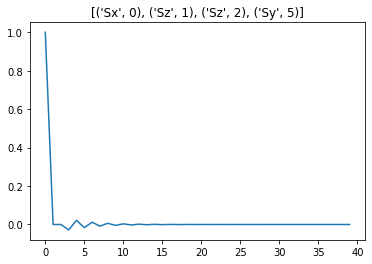

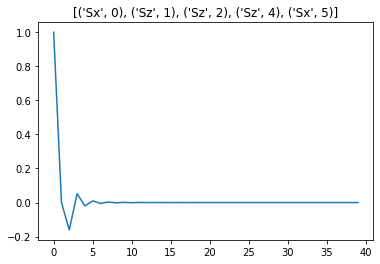

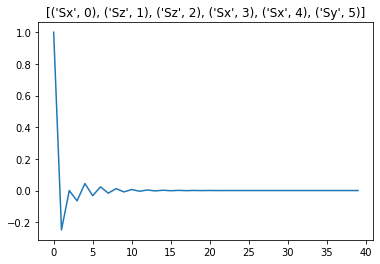

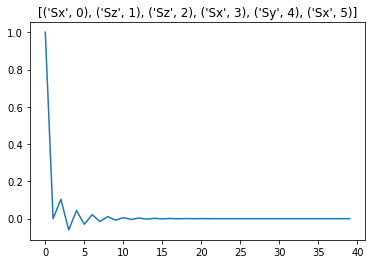

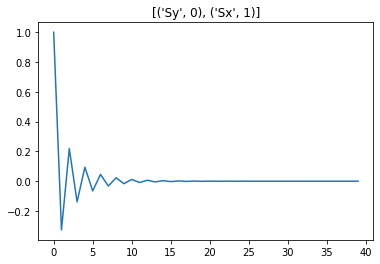

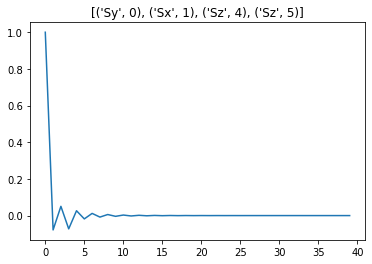

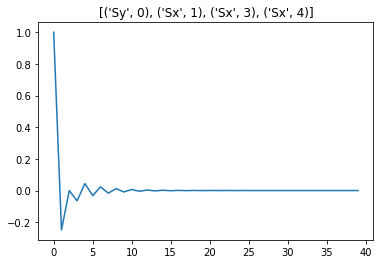

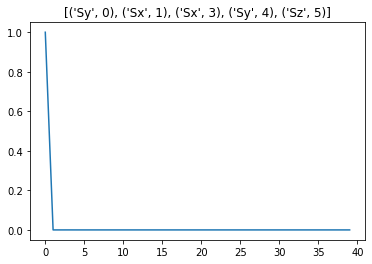

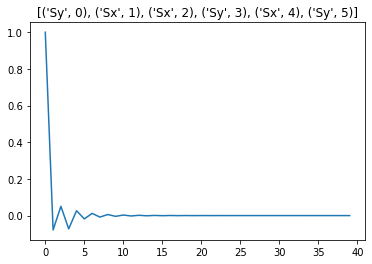

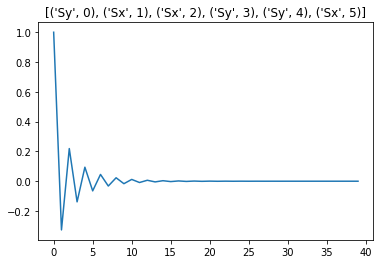

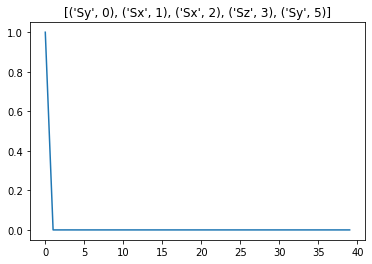

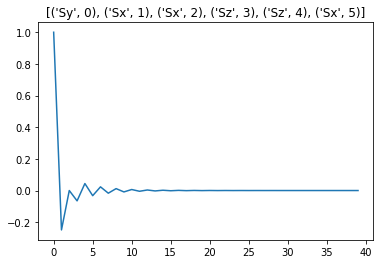

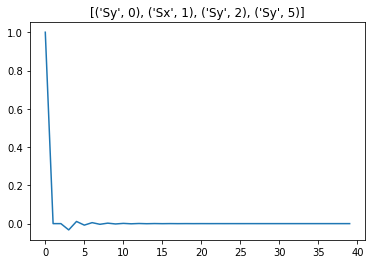

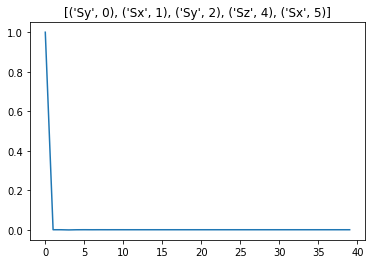

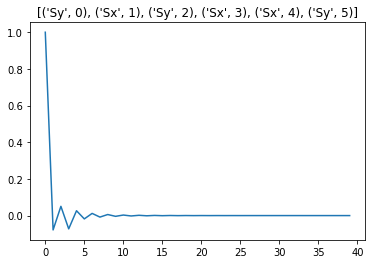

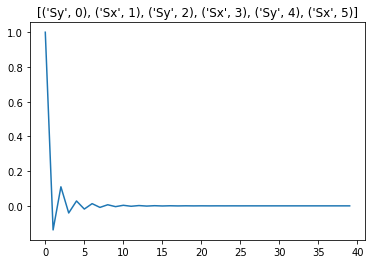

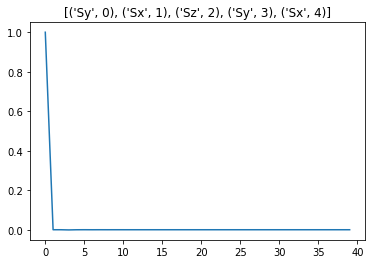

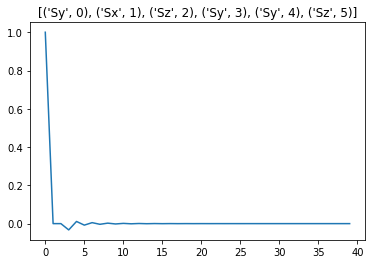

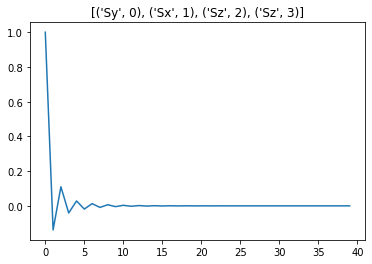

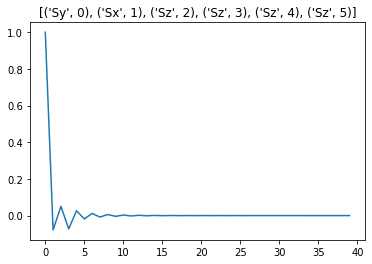

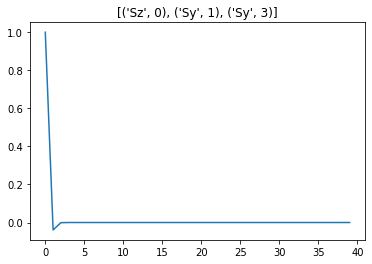

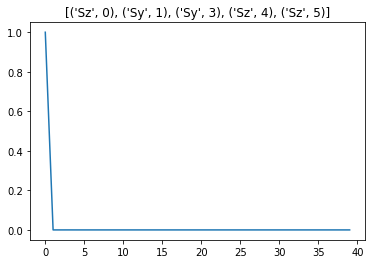

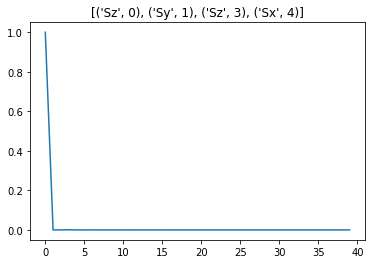

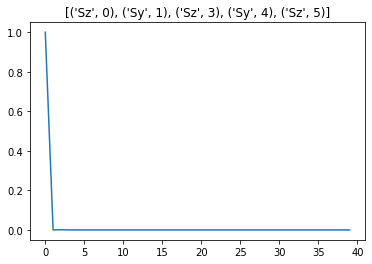

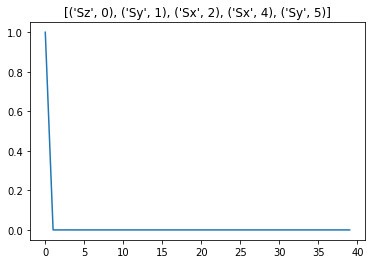

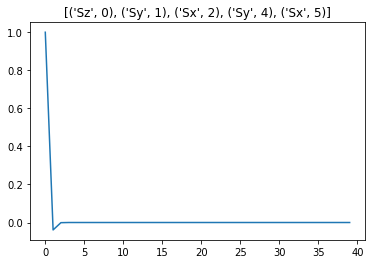

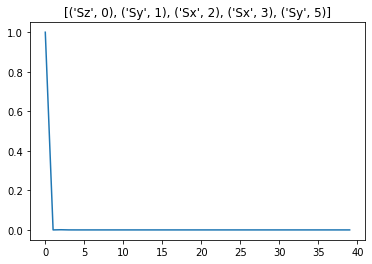

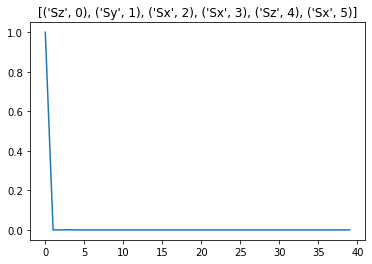

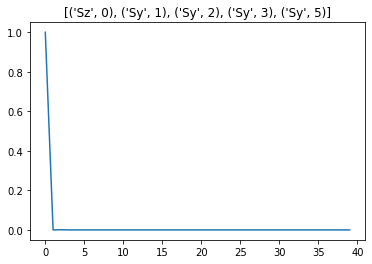

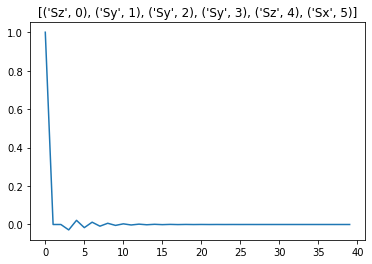

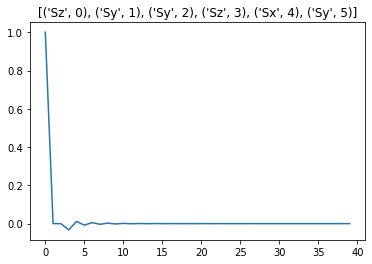

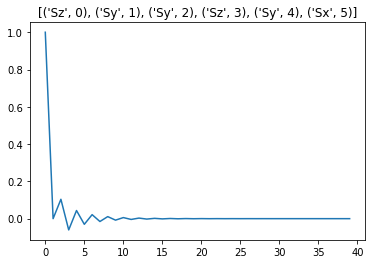

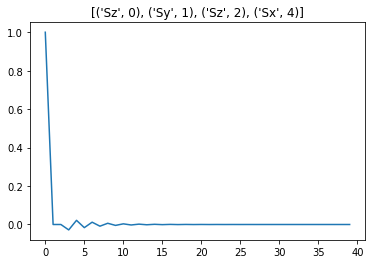

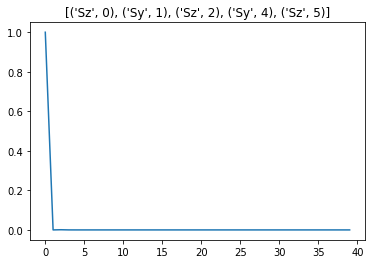

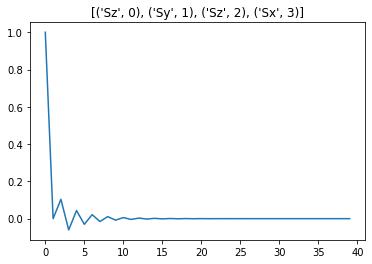

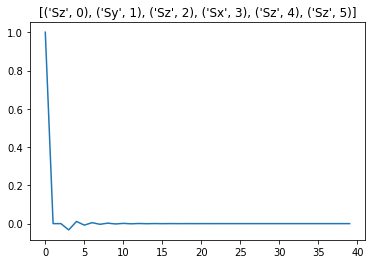

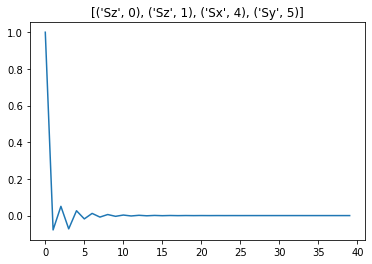

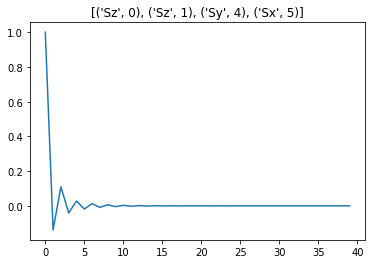

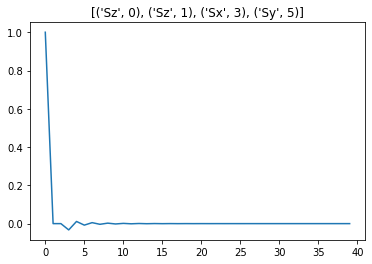

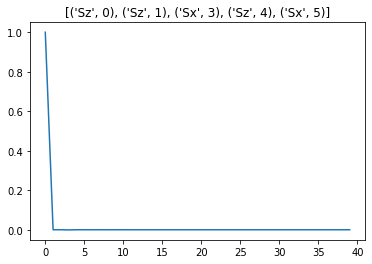

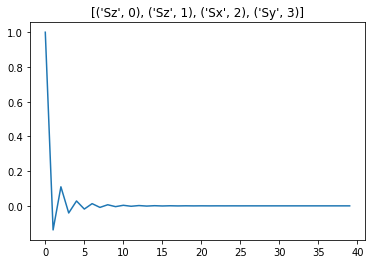

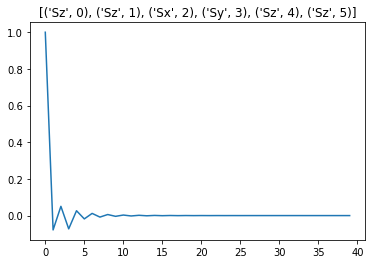

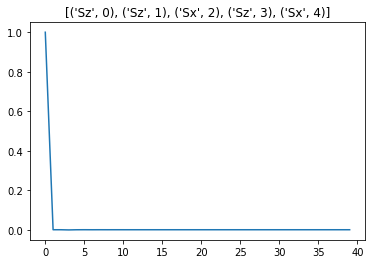

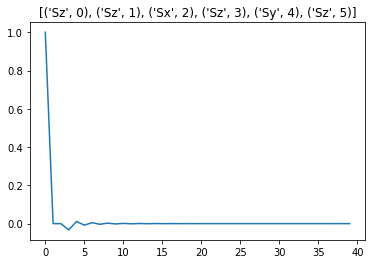

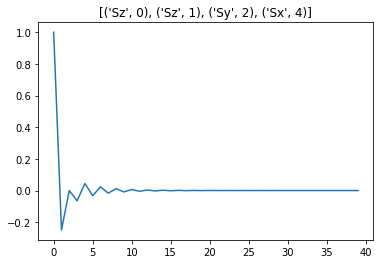

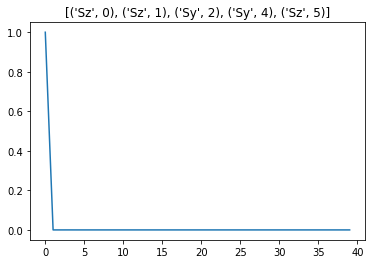

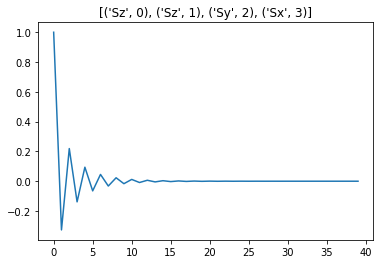

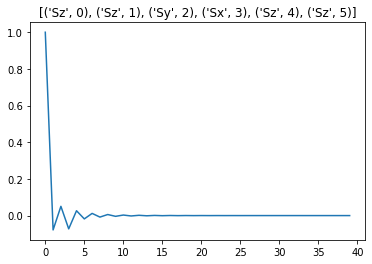

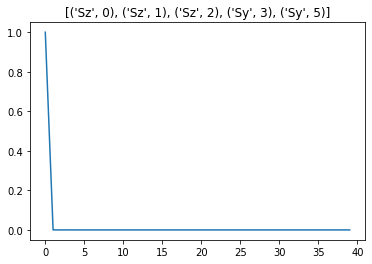

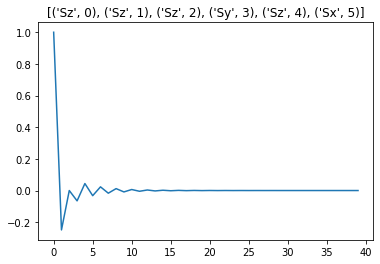

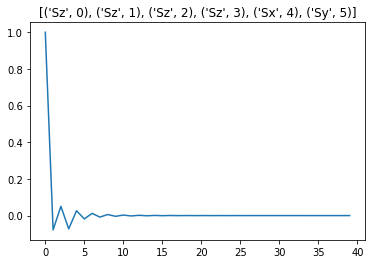

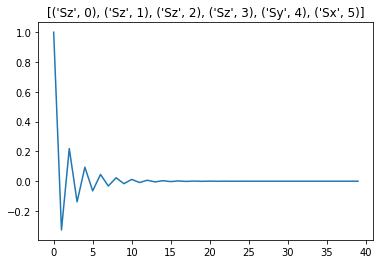

In [79]:
for op in (gen_local_order_parameter_candidates(3)):
    term_list = op.get_full_ops()
    tuple_list = list_to_tuple(term_list)
    ret = local_op_correlation(psi, tuple_list)
    plt.plot(ret)
    plt.title(str(tuple_list))
    plt.show()

In [90]:
def int_to_ch(n: int):
    if n==0:
        return 'I'
    elif n==1:
        return 'X'
    elif n==2:
        return 'Y'
    elif n==3:
        return 'Z'
    else:
        raise ValueError('Input `n` is not in {0, 1, 2, 3}')
        
int_to_ch(3)

'Z'

In [93]:
psi.L

80

FileNotFoundError: [Errno 2] No such file or directory: 'corr_figs_L_80/YIX.png'

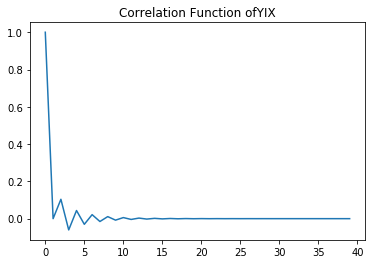

In [94]:
L = psi.L
for op in (gen_local_order_parameter_candidates(2)):
    term_list = op.get_full_ops()
    tuple_list = list_to_tuple(term_list)
    ret = local_op_correlation(psi, tuple_list)
    plt.plot(ret)
    
    param_name = ''.join([int_to_ch(n) for n in term_list])
    title_name = "Correlation Function of" + param_name
    plt.title(title_name)
    plt.savefig(f"corr_figs_L_{L}/" + param_name)
    plt.show()